In [84]:
from datetime import datetime
import local_helpers as lh
import vaex
import h3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Feature Engineering

### Previous demand as input

As we have given time series data, it is a common approach to use the demand of previous hours (or days etc.) as an input for the prediction. The assumption we hereby make is that the factors that influence the demand have not changed dramatically within the used time frames. We have decided to construct the following features from previous demand:

* 2 hour: The asssumption is that the demand should not change dramatically between three hours.
* 24 hours: The asssumption is that the current demand should be comparable to the demand exactly one day ago, as factors such as season, time of the day are the same.
* Average demand of the past week at the same day time: This feature is the average of all 7 demand observations of the past week at same time of the day. 

In [85]:
df_taxi_trips = vaex.open('./data/trips_prepared.hdf5')
df_taxi_trips.head()

df_taxi_trips["trip_start_day"] = df_taxi_trips.trip_start_timestamp.dt.day
df_taxi_trips["trip_start_month"] = df_taxi_trips.trip_start_timestamp.dt.month
df_taxi_trips["trip_start_hour"] = df_taxi_trips.trip_start_timestamp.dt.hour
df_taxi_trips["trip_start_minute"] = df_taxi_trips.trip_start_timestamp.dt.minute

In [116]:
# read and merge weather data
df_weather = pd.read_csv('data/weather_data_final.csv')
df_weather['date_time'] = pd.to_datetime(df_weather['date_time'])
df_weather['date_time'] = df_weather['date_time'].dt.ceil('H')
df_weather.rename(columns={'date_time': 'timestamp'}, inplace=True)

# cast data types
df_weather['temp'] = df_weather['temp'].str.replace('\xa0°F', '').astype(float).fillna(np.nan)
df_weather['dew_point'] = df_weather['dew_point'].str.replace('\xa0°F', '').astype(float).fillna(np.nan)
df_weather['humidity'] = df_weather['humidity'].str.replace('\xa0°%', '').astype(float).fillna(np.nan)
df_weather['wind_speed'] = df_weather['wind_speed'].str.replace('\xa0°mph', '').astype(float).fillna(np.nan)
df_weather['wind_gust'] = df_weather['wind_gust'].str.replace('\xa0°mph', '').astype(float).fillna(np.nan)
df_weather['pressure'] = df_weather['pressure'].str.replace('\xa0°in', '').astype(float).fillna(np.nan)
df_weather['precip'] = df_weather['precip'].str.replace('\xa0°in', '').astype(float).fillna(np.nan)

,date,time,temp,dew_point,humidity,wind_speed,wind_gust,pressure,precip,condition,timestamp
0,2017-01-01,00:53,33.0,24.0,70.0,8.0,0.0,29.45,0.0,Partly Cloudy,2017-01-01 01:00:00


In [86]:
RESOLUTION = 10
def geo_to_h3(row1, row2):
    return h3.geo_to_h3(row1,row2, RESOLUTION)

# Step 1: For each pickup and drop-off calculate the correct hexagon in the resolution
df_taxi_trips['pickup_hex'] = df_taxi_trips.apply(geo_to_h3, [df_taxi_trips['pickup_centroid_latitude'], df_taxi_trips['pickup_centroid_longitude']])
df_taxi_trips['dropoff_hex'] = df_taxi_trips.apply(geo_to_h3, [df_taxi_trips['dropoff_centroid_latitude'], df_taxi_trips['dropoff_centroid_longitude']])

In [87]:
# TODO: outsource everything in function -> making easy testing on different resolutions possible!
def prepare_dataset_with_hex_resolution(resolution):
    RESOLUTION = resolution
    # Step 1: For each pickup and drop-off calculate the correct hexagon in the resolution
    df_taxi_trips['pickup_hex'] = df_taxi_trips.apply(geo_to_h3, [df_taxi_trips['pickup_centroid_latitude'], df_taxi_trips['pickup_centroid_longitude']])
    df_taxi_trips['dropoff_hex'] = df_taxi_trips.apply(geo_to_h3, [df_taxi_trips['dropoff_centroid_latitude'], df_taxi_trips['dropoff_centroid_longitude']])
    
    ### Group by hour
    df_demand_vaex = df_taxi_trips.groupby(['trip_start_hour', 'trip_start_month', 'trip_start_day', 'pickup_hex']).agg({'demand': 'count'})

    # Add timestamp as preparation for resampling
    df_demand_vaex['timestamp'] = pd.to_datetime({'year': 2017, 'month': df_demand_vaex['trip_start_month'].to_numpy(), 'day': df_demand_vaex['trip_start_day'].to_numpy(), 'hour': df_demand_vaex['trip_start_hour'].to_numpy()}).to_numpy()

    # convert to pandas df
    df_demand = df_demand_vaex.to_pandas_df()


In [88]:
### Group by hour
df_demand_vaex = df_taxi_trips.groupby(['trip_start_hour', 'trip_start_month', 'trip_start_day', 'pickup_hex']).agg({'demand': 'count'})

# Add timestamp as preparation for resampling
df_demand_vaex['timestamp'] = pd.to_datetime({'year': 2017, 'month': df_demand_vaex['trip_start_month'].to_numpy(), 'day': df_demand_vaex['trip_start_day'].to_numpy(), 'hour': df_demand_vaex['trip_start_hour'].to_numpy()}).to_numpy()

# convert to pandas df
df_demand = df_demand_vaex.to_pandas_df()

In [90]:
### Creation of dummy df which contains hourly data dummy data over an entire year per hexagon

# Create a DateTimeIndex with hourly intervals for the year 2017
start_date = '2017-01-01 00:00:00'
end_date = '2017-12-31 23:00:00'
hourly_range = pd.date_range(start=start_date, end=end_date, freq='H')
num_entries_per_year = len(hourly_range)

hourly_range = np.tile(hourly_range,len(np.unique(df_demand.pickup_hex)))

# -1 values will indacte that these rows were artificially generated later on
data = {
    'trip_start_hour': -1,
    'trip_start_month': -1,
    'trip_start_day': -1,
    'pickup_hex': np.repeat(np.unique(df_demand.pickup_hex), num_entries_per_year),
    'demand': 0,
}

df_demand_hourly = pd.DataFrame(data, index=hourly_range)
df_demand_hourly= df_demand_hourly.set_index([df_demand_hourly.index, 'pickup_hex'])

# introduce multiindex for filling up the df with hourly index later on
df_demand=df_demand.set_index(['timestamp', 'pickup_hex'])
    
# insert df_demand 
df_demand_hourly.update(df_demand)

# clear up multi-index
df_demand_hourly=df_demand_hourly.reset_index()
df_demand_hourly.columns = ['timestamp','pickup_hex','trip_start_hour','trip_start_month','trip_start_day','demand']
df_demand_hourly

,timestamp,pickup_hex,trip_start_hour,trip_start_month,trip_start_day,demand
0,2017-01-01 00:00:00,8a266452180ffff,0.0,1.0,1.0,1.0
1,2017-01-01 01:00:00,8a266452180ffff,1.0,1.0,1.0,1.0
2,2017-01-01 02:00:00,8a266452180ffff,-1.0,-1.0,-1.0,0.0
3,2017-01-01 03:00:00,8a266452180ffff,-1.0,-1.0,-1.0,0.0
4,2017-01-01 04:00:00,8a266452180ffff,-1.0,-1.0,-1.0,0.0
...,...,...,...,...,...,...
3127315,2017-12-31 19:00:00,8a275936bc4ffff,-1.0,-1.0,-1.0,0.0
3127316,2017-12-31 20:00:00,8a275936bc4ffff,-1.0,-1.0,-1.0,0.0
3127317,2017-12-31 21:00:00,8a275936bc4ffff,-1.0,-1.0,-1.0,0.0
3127318,2017-12-31 22:00:00,8a275936bc4ffff,-1.0,-1.0,-1.0,0.0


In [91]:
# insert features 2 and 24 hours previous demand
df_demand_hourly['demand_h-1'] = df_demand_hourly.sort_values('timestamp').groupby('pickup_hex')['demand'].shift(2)
df_demand_hourly['demand_h-2'] = df_demand_hourly.sort_values('timestamp').groupby('pickup_hex')['demand'].shift(2)
df_demand_hourly['demand_h-24'] = df_demand_hourly.sort_values('timestamp').groupby('pickup_hex')['demand'].shift(24)

In [92]:
# df_demand_hourly['avg_non_zero_demand_season'] = df_demand_hourly.apply((lambda x: get_mean_demand(df_demand_hourly, x.trip_start_day, x.trip_start_month, x.trip_start_month, x.pickup_hex)), axis=1)

In [93]:
def get_mean_demand(df, hour, month, day, hexagon):
    winter = [12, 1, 2]
    spring = [3,4,5]
    summer = [6,7,8]
    autumn = [9,10,11]

    months = []
    if month in winter:
        months = winter
    elif month in spring:
        months = spring
    elif month in summer:
        months = summer
    else:
        months = autumn

    mean = df_demand_hourly.loc[(df_demand_hourly['pickup_hex'] == hexagon) &(df_demand_hourly['trip_start_hour'] == hour) & (df_demand_hourly['trip_start_day'] == day) & ((df_demand_hourly['trip_start_month'] == months[0]) | (df_demand_hourly['trip_start_month'] == months[1]) | (df_demand_hourly['trip_start_month'] == months[2]))]['demand'].mean()
    
    if np.isnan(mean):
        return 0
    else: 
        return mean

# Weather features
In the descriptive analysis, particularly the analysis of temporal demand patterns, we found that the temperature and demand curves follow similar directions. Therefore, we construct features based on temperature to enable models that capture this relationship.

### Include weather data
First, we have to include the weather data into the dataframe. For this we just need to merge the two datasets, as both are already in hourly frequency. The weather data propose data for minute 53 of an hour. Therefore, we round up to the nearest hour for each row. We suppose that the weather changes in seven minutes can be disregarded.

In [117]:
def merge_weather(df):
    df = df.merge(df_weather, on='timestamp', how='left')
    return df

### Temperature features
In addition to the current temperature, we are add the temperature from 1, 2, and 3 hours prior to the time of taxi demand. We suggest that past temperature conditions could potentially impact the decision to hire a taxi.

In [95]:
def get_past_temperature(df):
    df['temp_h-1'] = df.sort_values('timestamp').groupby('pickup_hex')['temp'].shift(1)
    df['temp_h-2'] = df.sort_values('timestamp').groupby('pickup_hex')['temp'].shift(2)
    df['temp_h-3'] = df.sort_values('timestamp').groupby('pickup_hex')['temp'].shift(3)
    return df

### Precipitation
We hypothesize that precipitation has a significant impact on demand. Therefore, we construct features that describe whether it has rained in the last 1-3 hours.

In [96]:
def get_past_precip(df):
    df['precip_h-1'] = df.sort_values('timestamp').groupby('pickup_hex')['precip'].shift(1)
    df['precip_h-2'] = df.sort_values('timestamp').groupby('pickup_hex')['precip'].shift(2)
    df['precip_h-3'] = df.sort_values('timestamp').groupby('pickup_hex')['precip'].shift(3)
    return df

### Season
We suggest that demand changes over seasons.

In [97]:
# long loading time
def determine_season(row):
    if datetime(2017, 12, 22) <= row.timestamp or row.timestamp < datetime(2017, 3, 20):
        return 'winter'
    elif datetime(2017, 3, 20) <= row.timestamp < datetime(2017, 6, 21):
        return 'spring'
    elif datetime(2017, 6, 21) <= row.timestamp < datetime(2017, 9, 23):
        return 'summer'
    else:
        return 'autumn'

def get_season(df):
    df['season'] = df.apply((lambda x: determine_season(x)), axis=1)
    df = pd.get_dummies(df, columns=['season'])
    return df

### Weekend feature
In the descriptive analysis we have seen that demand changes depending on weekend or not. Hence we engineer a feature "weekend" which is 1 for all rides on saturday & sunday and zero for all other days.

In [98]:
def get_weekend(df):
    df['weekend'] = df.apply((lambda x: 0 if x.timestamp.weekday() < 5 else 1), axis=1)
    return df

### Daytime features
In addition, descriptive analysis has shown that the time of day, i.e., whether it is night, morning, afternoon, or evening, plays an important role in determining demand. Therefore, we developed four characteristics, each indicating whether a trip occurs during the following times.
* Morning: 6 a.m. - 12 p.m.
* Afternoon: 12 noon - 6 p.m.
* Evening: 6 p.m. - 11 p.m.
* Night: 12 a.m. - 6 a.m.

In [99]:
def get_daytime(df):
    df['daytime'] = df["timestamp"].apply(lambda x: lh.get_pnt_day_with_pnt_week(x))
    df = pd.get_dummies(df, columns=['daytime'])
    return df

### Event Features
Events such as public holidays might influence the demand. In order to capture these patterns we introduce the public holiday feature

There were several public holidays in Boston:
* Martin Luther King Day: Monday, January 16, 2017
* Lincoln's Birthday: Monday, February 13, 2017
* Washington's Birthday (President's Day): Monday, February 20, 2017
* Memorial Day: Monday, May 29, 2017
* Independence Day: Tuesday, July 04, 2017
* Labor Day: Monday, September 04, 2017
* Columbus Day: Monday, October 09, 2017
* Veterans' Day: Friday, November 10, 2017
* Thanksgiving Day: Thursday, November 23, 2017
* Thanksgiving Day: Friday, November 24, 2017
* Christmas Day: Monday, December 25, 2017

These events might have influenced the demand

In [100]:
holiday_dates = [
    datetime(2017, 1, 2),   # New Year's Day
    datetime(2017, 1, 16),  # Martin Luther King Day
    datetime(2017, 2, 13),  # Lincoln's Birthday
    datetime(2017, 2, 20),  # Washington's Birthday (President's Day)
    datetime(2017, 5, 29),  # Memorial Day
    datetime(2017, 7, 4),   # Independence Day
    datetime(2017, 9, 4),   # Labor Day
    datetime(2017, 10, 9),  # Columbus Day
    datetime(2017, 11, 10), # Veterans' Day
    datetime(2017, 11, 23), # Thanksgiving Day
    datetime(2017, 11, 24), # Day after Thanksgiving
    datetime(2017, 12, 25), # Christmas Day
]

def get_holiday_dates(df):
    df['public_holiday'] = df.apply((lambda x: 1 if x.timestamp in holiday_dates else 0), axis=1)
    return df

# Correlation Analysis
We have different measurement scales:

Ordinal (natural order, but no quantifiable difference between values or binary):
- season_x 
- daytime_x
- hour_of_day
Metric (equidistant scale):
- temp
- demand
- precipitation
Nominal:
- public_holiday
- weekend

We do 2 different analysis:
- Metric <-> Metric (Pearson)
- Ordinal & Nominal <-> Metric, Ordinal & Nominal <-> Ordinal & Nominal (Spearman)

In [120]:
# 6 Min loading time
# engineer features
df_demand = merge_weather(df_demand_hourly)
df_demand = get_past_temperature(df_demand)
df_demand = get_past_precip(df_demand)
df_demand = get_season(df_demand)
df_demand = get_weekend(df_demand)
df_demand = get_daytime(df_demand)
df_demand = get_holiday_dates(df_demand)
df_demand.head()

,timestamp,pickup_hex,trip_start_hour,trip_start_month,trip_start_day,demand,demand_h-1,demand_h-2,demand_h-24,date,...,weekend,daytime_afternoon_week,daytime_afternoon_weekend,daytime_evening_week,daytime_evening_weekend,daytime_morning_week,daytime_morning_weekend,daytime_night_week,daytime_night_weekend,public_holiday
0,2017-01-01 00:00:00,8a266452180ffff,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,1,0
1,2017-01-01 01:00:00,8a266452180ffff,1.0,1.0,1.0,1.0,NaN,NaN,NaN,2017-01-01,...,1,0,0,0,0,0,0,0,1,0
2,2017-01-01 02:00:00,8a266452180ffff,-1.0,-1.0,-1.0,0.0,1.0,1.0,NaN,2017-01-01,...,1,0,0,0,0,0,0,0,1,0
3,2017-01-01 03:00:00,8a266452180ffff,-1.0,-1.0,-1.0,0.0,1.0,1.0,NaN,2017-01-01,...,1,0,0,0,0,0,0,0,1,0
4,2017-01-01 04:00:00,8a266452180ffff,-1.0,-1.0,-1.0,0.0,0.0,0.0,NaN,2017-01-01,...,1,0,0,0,0,0,0,0,1,0


<AxesSubplot: >

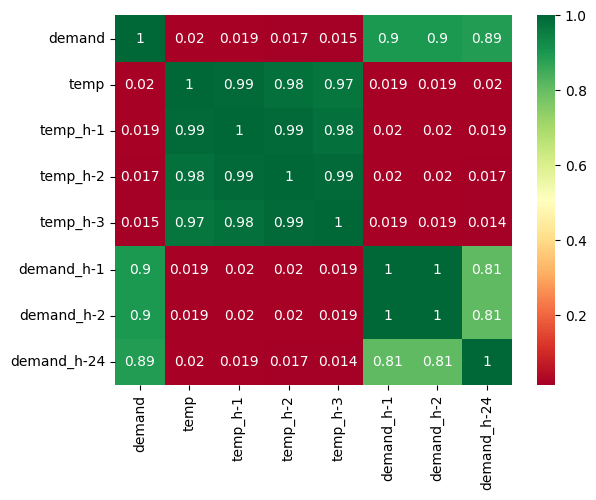

In [121]:
metric = df_demand[["demand", "temp", "temp_h-1", "temp_h-2", "temp_h-3", "demand_h-1", "demand_h-2", "demand_h-24"]]
sns.heatmap(metric.corr(method="pearson"), annot=True, cmap="RdYlGn")

<AxesSubplot: >

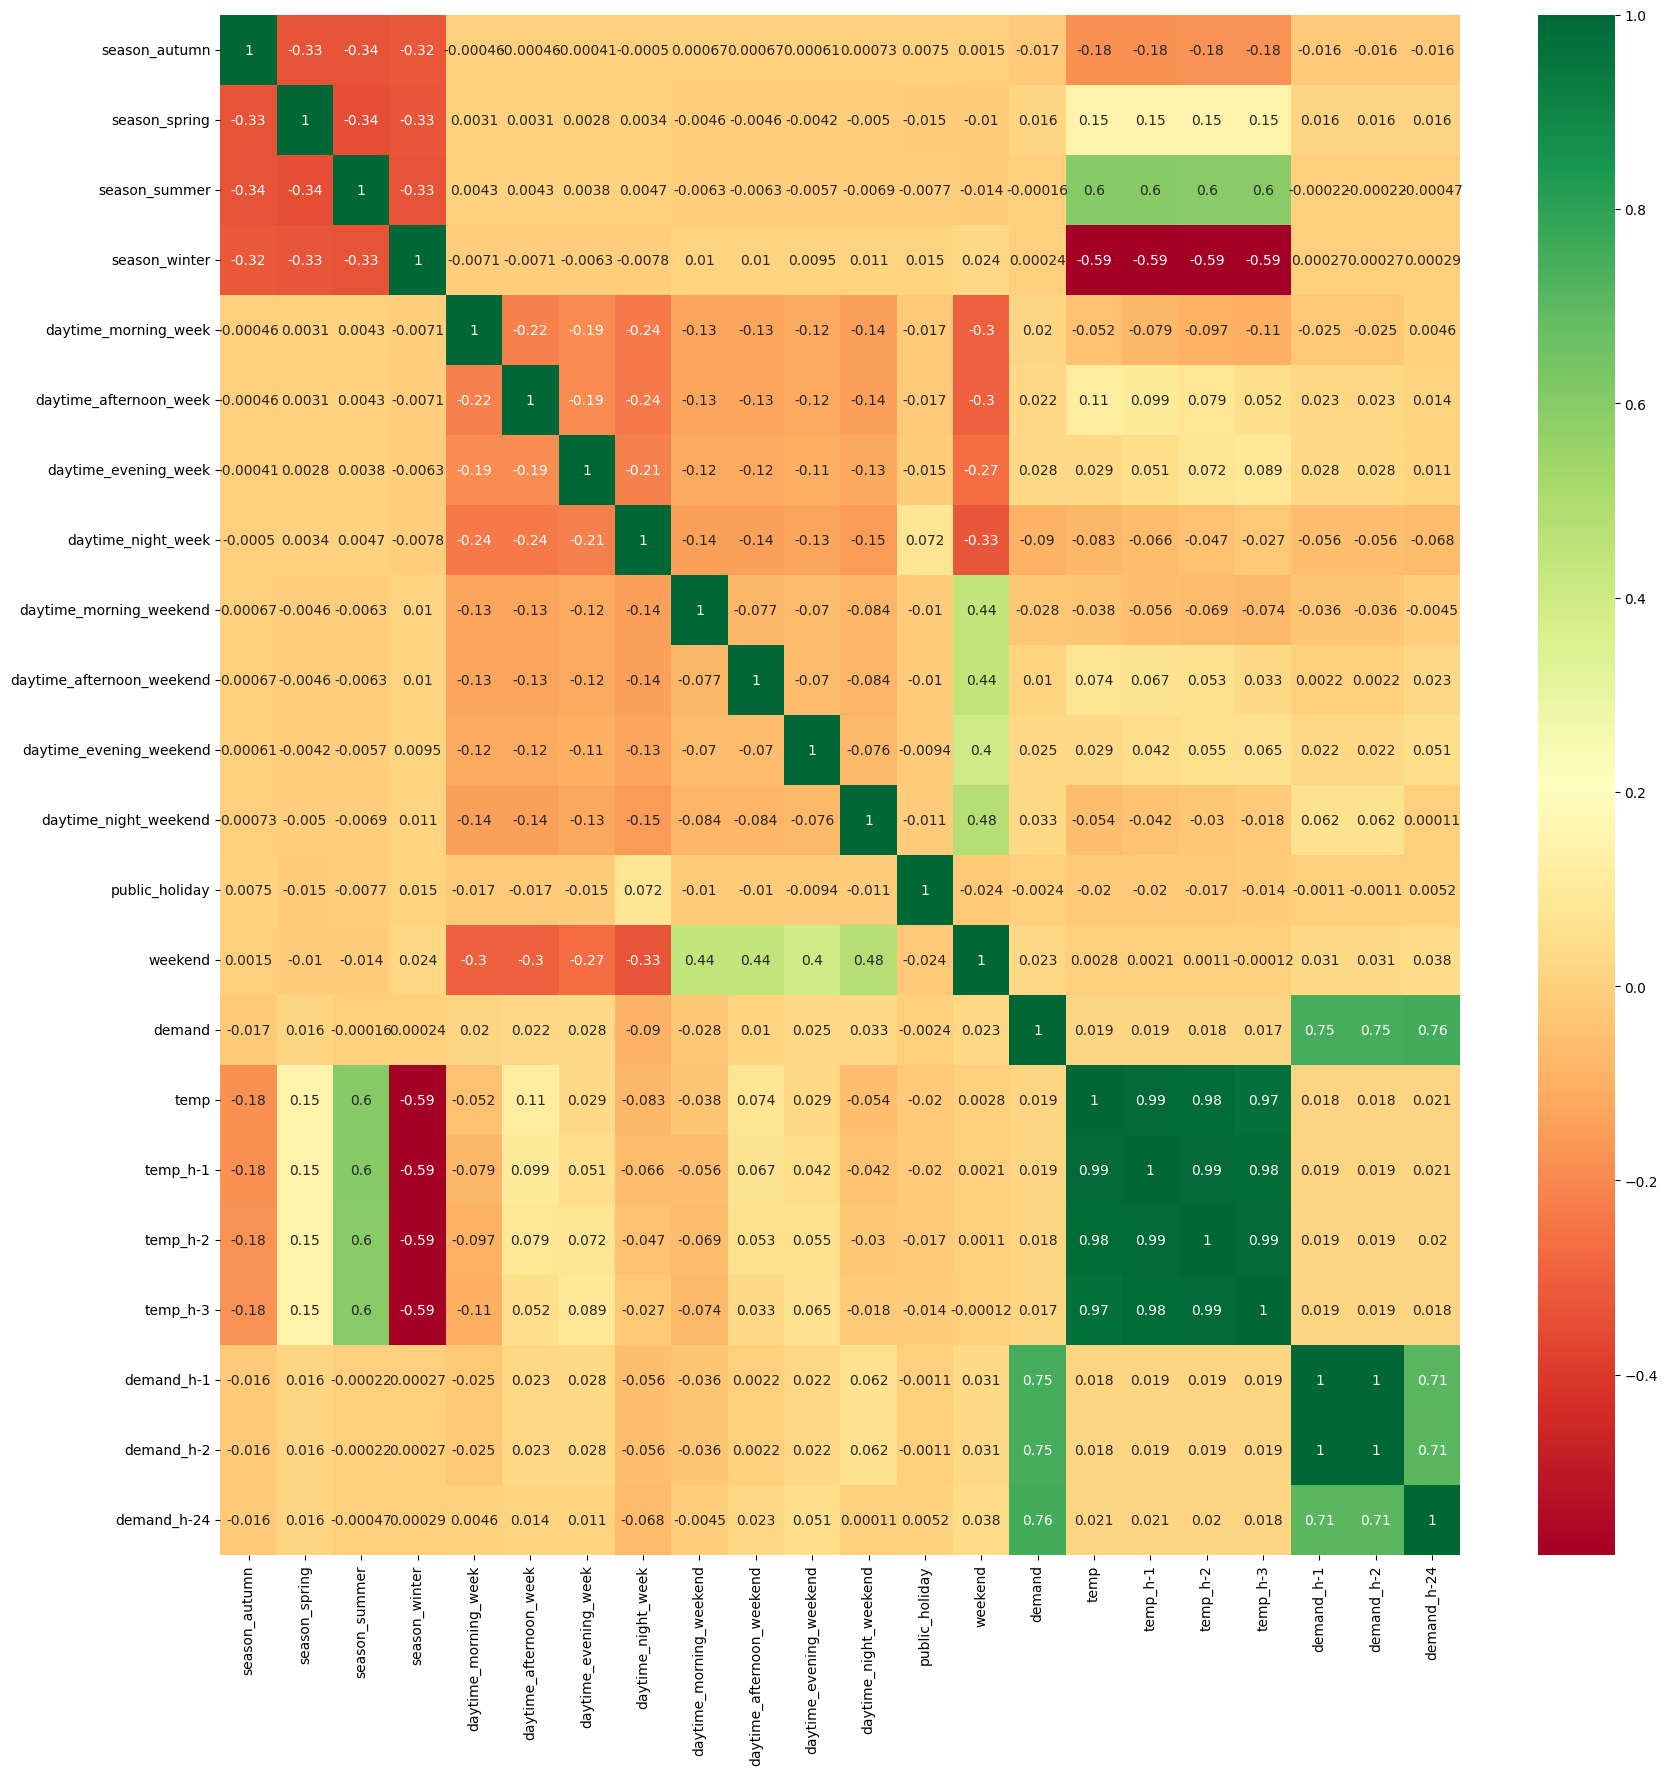

In [122]:
ordinal_and_nominal = df_demand[
        ["season_autumn", "season_spring", "season_summer", "season_winter", "daytime_morning_week",
        "daytime_afternoon_week", "daytime_evening_week", "daytime_night_week", "daytime_morning_weekend",
        "daytime_afternoon_weekend", "daytime_evening_weekend", "daytime_night_weekend", "public_holiday",
        "weekend"]] #"hour"
plt.figure(figsize=(20, 20))
sns.heatmap(pd.concat([ordinal_and_nominal, metric], axis=1).corr(method="spearman"), annot=True, cmap="RdYlGn")